In [1]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
%reload_ext autoreload
%autoreload 2
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from utils import DataLoader, RunModel

## AD/NC Performance

### Load Models

In [5]:
fusion_rf, X_train, X_test, y_train, y_test = pickle.load(open('models/fusion_rf', 'rb'))
mri_rf, mri_X_train, mri_X_test, mri_y_train, mri_y_test = pickle.load(open('models/mri_rf', 'rb'))
neuro_rf, neuro_X_train, neuro_X_test, neuro_y_train, neuro_y_test = pickle.load(open('models/neuro_rf', 'rb'))

In [6]:
print(f"Fusion Model -  Accuracy: {fusion_rf.accuracy}. F1-Score: {fusion_rf.f1}. AUC: {fusion_rf.auc}")
print(f"MRI Model    -  Accuracy: {mri_rf.accuracy}. F1-Score: {mri_rf.f1}. AUC: {mri_rf.auc}")
print(f"Neuro Model  -  Accuracy: {neuro_rf.accuracy}. F1-Score: {neuro_rf.f1}. AUC: {neuro_rf.auc}")

Fusion Model -  Accuracy: 0.9641350210970464. F1-Score: 0.9594272076372315. AUC: 0.996947113226183
MRI Model    -  Accuracy: 0.8452914798206278. F1-Score: 0.5576923076923077. AUC: 0.883378317588844
Neuro Model  -  Accuracy: 0.7399103139013453. F1-Score: 0.18309859154929578. AUC: 0.5266194331983807


In [ ]:
feature_names = X_train.columns.values.tolist()

## Performance Measures

#### Load best model

In [8]:
gridsearch_rf, gs_X_train, gs_X_test, gs_y_train, gs_y_test = pickle.load(open('models/gridsearch_rf', 'rb'))

In [9]:
rf_gr_pred = gridsearch_rf.predict(gs_X_test)
accuracy = accuracy_score(gs_y_test, rf_gr_pred)
f1 = f1_score(gs_y_test, rf_gr_pred)
rf_gr_probs = gridsearch_rf.predict_proba(gs_X_test)
rf_gr_probs = rf_gr_probs[:, 1]
rf_gr_auc = roc_auc_score(gs_y_test, rf_gr_probs)

In [10]:
print(f"Accuracy: {accuracy}. F1-Score: {f1}. AUC: {rf_gr_auc}")

Accuracy: 0.9662447257383966. F1-Score: 0.9619047619047618. AUC: 0.9972164855885787


#### Confusion Matrix

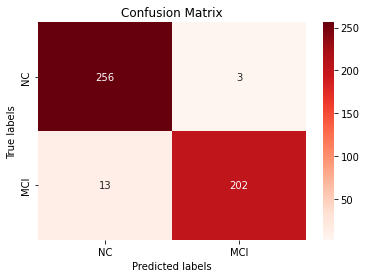

In [12]:
cm = confusion_matrix(gs_y_test, rf_gr_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Reds');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['NC', 'MCI']); ax.yaxis.set_ticklabels(['NC', 'MCI']);

plt.savefig('plots/ADNC-ConfusionMatrix.png')

#### ROC curve
Plots the **False Positive Rate (FPR)** on the x-axis and the **True Positive Rate (TPR)** on the y-axis.

In [13]:
r_probs = [0 for _ in range(len(y_test))]
r_auc = roc_auc_score(y_test, r_probs)
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))

Random (chance) Prediction: AUROC = 0.500


In [14]:
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, fusion_rf.probs)
mri_fpr, mri_tpr, _ = roc_curve(mri_y_test, mri_rf.probs)
neuro_fpr, neuro_tpr, _ = roc_curve(neuro_y_test, neuro_rf.probs)

rf_gr_fpr, rf_gr_tpr, _ = roc_curve(y_test, rf_gr_probs)

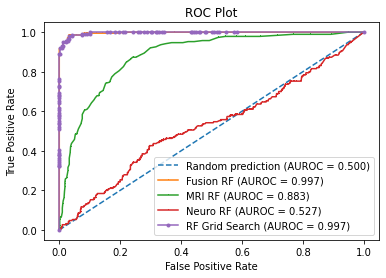

In [16]:
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(rf_fpr, rf_tpr, marker=',', label='Fusion RF (AUROC = %0.3f)' % fusion_rf.auc)
plt.plot(mri_fpr, mri_tpr, marker=',', label='MRI RF (AUROC = %0.3f)' % mri_rf.auc)
plt.plot(neuro_fpr, neuro_tpr, marker=',', label='Neuro RF (AUROC = %0.3f)' % neuro_rf.auc)
plt.plot(rf_gr_fpr, rf_gr_tpr, marker='.', label='RF Grid Search (AUROC = %0.3f)' % rf_gr_auc)


plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('plots/ADNC-ROCCurve.png')
plt.show()